# CONDITIONAL MLP
Let's train a mlp architecture for the two moons distribution, conditioned on the center of the distribution

In [1]:
import torch.distributions as tfd
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.pylab as pylab

plt.style.use("dark_background")
params = {
    'legend.fontsize': 20,
    'figure.figsize': (5, 5),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 20 # for annotate
}
pylab.rcParams.update(params)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def two_moons(modes=128, width=0.1, size=1, offset=0, device=DEVICE) -> tfd.Distribution:
    """
    Returns a 2 moons distributions from a mixture of  gaussian distributions
    :param modes: Number of modes inside each moon
    :param width: Width of the moons
    :param size: scales the coordinates by this amount
    :param offset: shifts the distribution center in x and y by the same amount
    """
    outer_circ_x = torch.cos(torch.linspace(0, np.pi, modes)) - .5 + offset
    outer_circ_y = torch.sin(torch.linspace(0, np.pi, modes)) - .25 + offset
    inner_circ_x = - torch.cos(torch.linspace(0, np.pi, modes)) + .5 + offset
    inner_circ_y = - torch.sin(torch.linspace(0, np.pi, modes)) + .25 + offset
    x = torch.concat([outer_circ_x, inner_circ_x])
    y = torch.concat([outer_circ_y, inner_circ_y])
    coords = size * torch.stack([x, y], dim=1).to(device)
    mixture = tfd.Categorical(probs=torch.ones(2*modes).to(device), validate_args=False)  # Uniform
    component = tfd.Independent(tfd.Normal(loc=coords, scale=width, validate_args=False), 1)  # Diagonal Multivariate Normal
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)

def density_scatter(points, fig=None, ax=None, sort=True, bins=40, cmap="magma", norm=None, ticks=None, colorbar=False, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    x = points[:, 0]
    y = points[:, 1]
    if ax is None:
        fig, ax = plt.subplots()
    data, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    x_bins = 0.5 * (x_edges[1:] + x_edges[:-1])
    y_bins = 0.5 * (y_edges[1:] + y_edges[:-1])
    z = interpn((x_bins, y_bins), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    if norm is None:
        norm = Normalize(vmin=z.min(), vmax=z.max())
    ax.scatter(x, y, c=z, cmap=cmap, norm=norm, **kwargs)
    if fig is not None:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        box = ax.get_position()
        cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
        fig.colorbar(sm, cax=cax, ticks=ticks)
        cax.set_ylabel('Density')
    return ax


def density_contours(density_function, xmin, xmax, ymin, ymax, confidence_intervals, dx=0.01, dy=0.01, fig=None, ax=None):
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    n = x.size
    m = y.size
    points = np.stack(np.meshgrid(x, y), axis=-1).reshape((-1, 2))
    p = density_function(torch.tensor(points).to(DEVICE)).detach().numpy().reshape([m, n])
    if ax is None:
        fig, ax = plt.subplots()

    cumul = np.sort(p.ravel() * dx * dy)[::-1].cumsum()
    ps = []
    len_ci = len(confidence_intervals)
    for ci in confidence_intervals:
        p_at_ci = np.sort(p.ravel())[::-1][np.argmin((cumul - ci)**2)]
        ps.append(p_at_ci)
    cs = ax.contour(x, y, p, levels=ps[::-1], colors=[plt.cm.cool(i/(len_ci-1)) for i in range(len_ci)], linewidths=2, linestyles="--")

    def fmt(x):
        ci = cumul[np.argmin((x - np.sort(p.ravel())[::-1])**2)]
        s = f"{ci*100:.1f}"
        if s.endswith("0"):
            s = f"{ci*100:.0f}"
        return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)

    return ax


class Dataset(torch.utils.data.Dataset):
    def __init__(self, distribution, offsets, size=2000, device=DEVICE):
        self.distribution = distribution
        self.size = size
        self.device = device
        self.offsets = offsets

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        # This method now returns not only the data but also the condition(s)
        dist = self.distribution(width = 0.1, offset = self.offsets[index])
        return dist.sample([1]).to(self.device).view(-1), torch.tensor(self.offsets[index], dtype = torch.float32).to(self.device).view(-1)


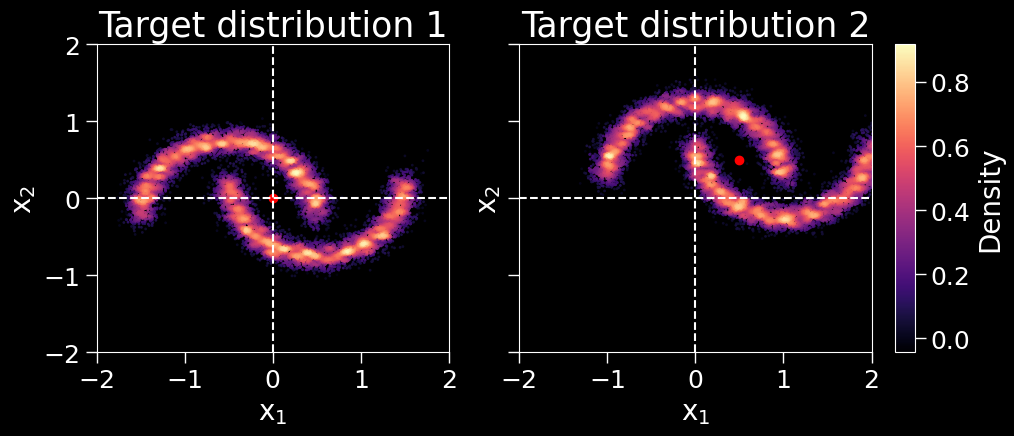

In [4]:
sigma_x0 = 0.1 # width of distributions

c1, c2 = 0, 0.5 # two different centers of distributions

dist1 = two_moons(width=sigma_x0, offset = c1)
dist2 = two_moons(width=sigma_x0, offset = c2)

x1 = dist1.sample([10000])
x2 = dist2.sample([10000])

xmax = 2
ymax = 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1 = density_scatter(x1.cpu().numpy(), ax=ax1, s=1)
ax1.set_title("Target distribution 1")
ax1.set_ylabel(r"x$_{2}$")
ax1.set_xlabel(r"x$_{1}$")
ax1.set_xlim(-xmax, xmax)
ax1.set_ylim(-ymax, ymax)
ax1.scatter(c1, c1, color = 'red')
ax1.axvline(x = 0, ls = '--', color = 'white')
ax1.axhline(y = 0, ls = '--', color = 'white')

ax2 = density_scatter(x2.cpu().numpy(), fig=fig, ax=ax2, s=1)
ax2.set_title("Target distribution 2")
ax2.set_ylabel(r"x$_{2}$")
ax2.set_xlabel(r"x$_{1}$")
ax2.set_xlim(-xmax, xmax)
ax2.set_ylim(-ymax, ymax)
ax2.scatter(c2, c2, color = 'red')
ax2.axvline(x = 0, ls = '--', color = 'white')
ax2.axhline(y = 0, ls = '--', color = 'white')

plt.show()

Using the Variance Exploding SDE


Epoch 50 | Cost: 1.1e+00 |: 100%|██████████| 50/50 [10:11<00:00, 12.22s/it]

Finished training after 0.170 hours.


Text(0, 0.5, 'DSM loss')

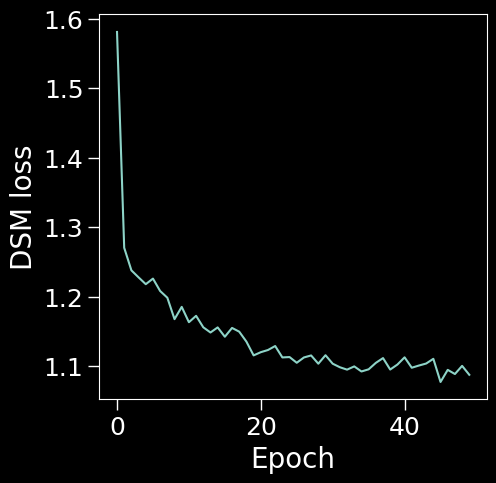

In [2]:
from score_models import ScoreModel, MLP


offsets = np.repeat(np.linspace(0,1,20),2000)

size = len(offsets)

dataset = Dataset(distribution=two_moons, offsets=offsets, size=size)


hyperparameters = {
    "dimensions": 2,
    "units": 100,
    "layers": 4,
    "time_embedding_dimensions": 100,
    "embedding_scale": 64,
    "activation": "swish",
    "time_branch_layers": 1,
    "bottleneck": 32,
    "attention": True,
    "conditioning": ["Input"], 
    "conditioning_channels": [1]
}
net = MLP(**hyperparameters).to(DEVICE)
model = ScoreModel(model=net, sigma_min=1e-2, sigma_max=10)

# Define any preprocessing function if needed
def preprocessing_fn(x):
    return x

# Set the hyperparameters and other options for training
learning_rate = 1e-3
batch_size = 256
epochs = 50
ema_decay = 0.99
checkpoints_directory = "models"
checkpoints = 10 # save a checkpoint every 10 epochs
models_to_keep = 1 # only keep one model, erase previous ones
seed = 42

# Fit the model to the dataset
losses = model.fit(
    dataset,
    preprocessing_fn=preprocessing_fn,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    ema_decay=ema_decay,
    checkpoints_directory=checkpoints_directory,
    checkpoints=checkpoints,
    models_to_keep=models_to_keep,
    seed=seed
    )
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("DSM loss")


Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 7.1e-01: 100%|██████████| 100/100 [00:01<00:00, 67.67it/s]
Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 7.1e-01: 100%|██████████| 100/100 [00:01<00:00, 66.32it/s]


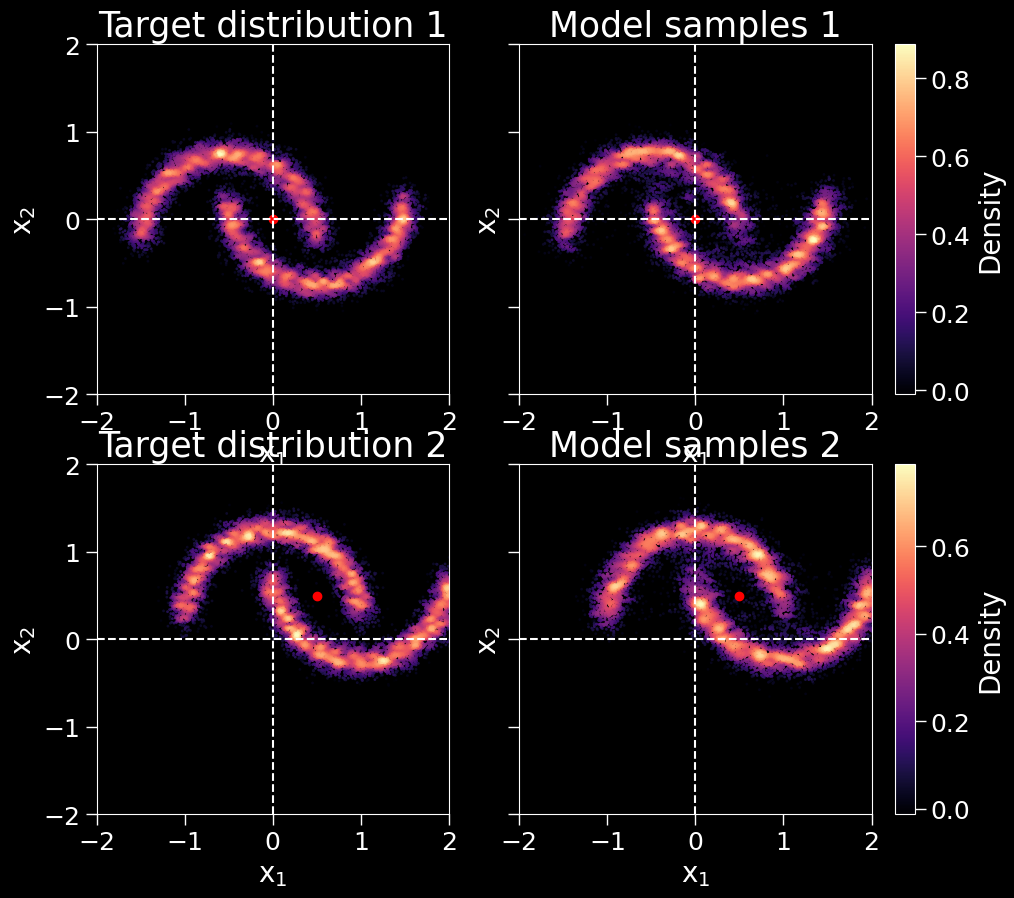

In [5]:
N = 100 # Number of Euler-Maruyama steps

center1 = 0
samples1 = model.sample(shape=[10000, 2], steps=N, condition=[torch.ones((10000,1))*center1])
dist1 = two_moons(width=sigma_x0, offset=center1)
x1 = dist1.sample([10000])

center2 = 0.5
samples2 = model.sample(shape=[10000, 2], steps=N, condition=[torch.ones((10000,1))*center2])
dist2 = two_moons(width=sigma_x0, offset=center2)
x2 = dist2.sample([10000])

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
ax[0,0] = density_scatter(x1.cpu().numpy(), ax=ax[0,0], s=1)
ax[0,0].set_title("Target distribution 1")
ax[0,0].set_ylabel(r"x$_{2}$")
ax[0,0].set_xlabel(r"x$_{1}$")
ax[0,0].set_xlim(-xmax, xmax)
ax[0,0].set_ylim(-ymax, ymax)
ax[0,0].axvline(x = 0, ls = '--', color = 'white')
ax[0,0].axhline(y = 0, ls = '--', color = 'white')
ax[0,0].scatter(center1, center1, color = 'red')


ax[0,1] = density_scatter(samples1.cpu().numpy(), fig=fig, ax=ax[0,1], s=1)
ax[0,1].set_title("Model samples 1")
ax[0,1].set_ylabel(r"x$_{2}$")
ax[0,1].set_xlabel(r"x$_{1}$")
ax[0,1].set_xlim(-xmax, xmax)
ax[0,1].set_ylim(-ymax, ymax)
ax[0,1].axvline(x = 0, ls = '--', color = 'white')
ax[0,1].axhline(y = 0, ls = '--', color = 'white')
ax[0,1].scatter(center1, center1, color = 'red')


ax[1,0] = density_scatter(x2.cpu().numpy(), ax=ax[1,0], s=1)
ax[1,0].set_title("Target distribution 2")
ax[1,0].set_ylabel(r"x$_{2}$")
ax[1,0].set_xlabel(r"x$_{1}$")
ax[1,0].set_xlim(-xmax, xmax)
ax[1,0].set_ylim(-ymax, ymax)
ax[1,0].axvline(x = 0, ls = '--', color = 'white')
ax[1,0].axhline(y = 0, ls = '--', color = 'white')
ax[1,0].scatter(center2, center2, color = 'red')


ax[1,1] = density_scatter(samples2.cpu().numpy(), fig=fig, ax=ax[1,1], s=1)
ax[1,1].set_title("Model samples 2")
ax[1,1].set_ylabel(r"x$_{2}$")
ax[1,1].set_xlabel(r"x$_{1}$")
ax[1,1].set_xlim(-xmax, xmax)
ax[1,1].set_ylim(-ymax, ymax)
ax[1,1].axvline(x = 0, ls = '--', color = 'white')
ax[1,1].axhline(y = 0, ls = '--', color = 'white')
ax[1,1].scatter(center2, center2, color = 'red')


plt.show()


# LIKELIHOOD ESTIMATION
We can also take a look at the likelihood for both condition values 

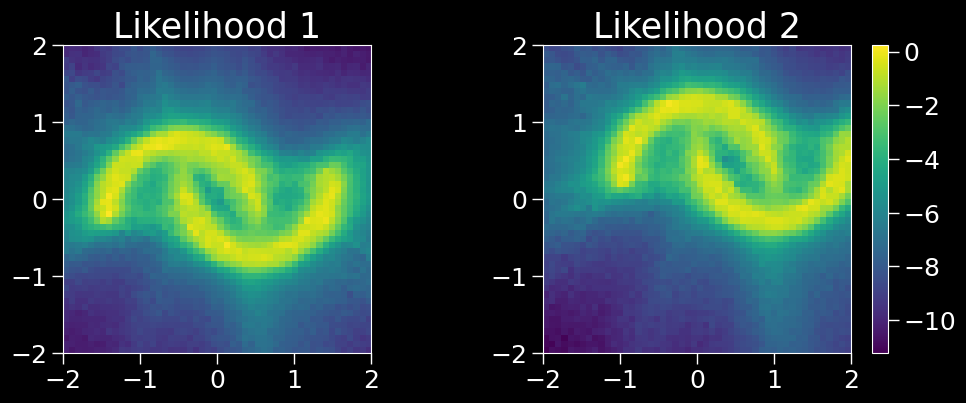

In [8]:

N_steps = 100

xs = np.linspace(-xmax, xmax, 50)
ys = np.linspace(-ymax, ymax, 50)

XX, YY = np.meshgrid(xs, ys)

ZZ1 = np.zeros_like(XX)
ZZ2 = np.zeros_like(XX)

for ii in range(len(xs)):
    for jj in range(len(ys)):
        ZZ1[ii, jj] = model.log_likelihood(torch.tensor([[xs[ii], ys[jj]]], dtype=torch.float32), torch.tensor([[center1]], dtype=torch.float32), ode_steps=N_steps)
        ZZ2[ii, jj] = model.log_likelihood(torch.tensor([[xs[ii], ys[jj]]], dtype=torch.float32), torch.tensor([[center2]], dtype=torch.float32), ode_steps=N_steps)

# Find the global min and max for consistent normalization
vmin = min(ZZ1.min(), ZZ2.min())
vmax = max(ZZ1.max(), ZZ2.max())

fig, ax = plt.subplots(1, 2, figsize = (12,4))
im1 = ax[0].imshow(ZZ1.T, origin='lower', extent=(-xmax, xmax, -ymax, ymax), vmin=vmin, vmax=vmax)
ax[0].set_title('Likelihood 1')

im2 = ax[1].imshow(ZZ2.T, origin='lower', extent=(-xmax, xmax, -ymax, ymax), vmin=vmin, vmax=vmax)
ax[1].set_title('Likelihood 2')

fig.colorbar(im2, ax=ax[1])

plt.show()
